# Milestone Report: Displaying Large Organizational Networks (Springboard Capstone Project 1)

Despite their effectiveness as tools for studying complex systems, many large networks are difficult to describe, understand, and visualize. Even when the networks are not densely connected, their maps may be dense, with nodes, links, and labels all overlapping and obscuring each other. Network statistics help an analyst to understand such a large network, but can be difficult to use to communicate to non-specialists. And, indeed, communicating these networks to non-specialists is a key task of many network analysts.

We can see just how much a problem this is by looking at several maps from a case study of networked governance. In 2014 and 2015, researcher with the Vermont Experimental Program to Stimulate Competitive Research (Vermont EPSCoR),a branch of NSF EPSCoR, gathered two editions of an organizational network survey which gathered data on the networks that make and implement water quality policy in Vermont’s portion of the Lake Champlain Basin (LCB). The survey gathered data on 5 different ways that organizations could interact. We shall start by looking at some of these networks.

Despite Springboard's focus on Python and its growing popularity in data science, this report will proceed using R. This is necessary for the final portions of this report and for building a tool to display networks to a generalist audience, which Python does not currently support, while R offers a platform building this tool with R's $shiny$ package.

In [1]:
# setup workspace
setwd("~/In Class Notes/Springboard/capstone projects/Visualizing_Gov_Nets")
options(stringsAsFactors = F)

# load in the necessary R packages
library(igraph)
library(networkD3)
library(dplyr)

# this code is for a function that filters edgelists for the limited organization lists that network slices
#   will need later on.
filter.el <- function( el, orgs ) {
  # this function takes a vector of org names and returns a new edge list containing
  # the function relies on vectorized code to make sure it runs fast
  # the nodes that are to be included in the final edgelist are passed in a vector or org names
  # initial edgelist, respectively, area "to list" and a "from list" are generated where the 
  #   to node and the from node from the included in the passed vector of org names
  # edges must be in both lists to be included in the final edgelist
  # vectorization requires that only one column of data be considered at a time
  # to allow for comparison of one column, data are concatented into comparable string representations
  # only those edges with string representations found in both lists are included in the final data
  
  el.from <- el[el$from %in% orgs,]           # get edges where the from node is in the org vector ("from list")
  el.to <- el[el$to %in% orgs,]               # get edges where the to node is in the org vector ("to list")
  
  
  # get edge string represtations for the dyads in both the to and from lists
  # the representations are appended as a new, 3rd column
  el.from$string <- paste(el.from$from,
                          "-",
                          el.from$to,
                          sep = "")
  el.to$string <- paste(el.to$from,
                        "-",
                        el.to$to,
                        sep = "")
  
  # select only those dyads where the string representation is in both lists
  #  by getting the dyads in the from list that are also in the to list
  el.filtered <- el.from[el.from$string %in% el.to$string,]
  
  return( unique( el.filtered[,-3]) )        # return the filtered edgelist, w/out the string representation
}


Attaching package: 'igraph'

The following objects are masked from 'package:stats':

    decompose, spectrum

The following object is masked from 'package:base':

    union


Attaching package: 'dplyr'

The following objects are masked from 'package:igraph':

    as_data_frame, groups, union

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



## Data and Data Wrangling

Before we look at the maps, we need to consider the data that will be included in the maps, how the data was obtained, cleaned, stored, and prepared for this project. This process was initially carried using Excel and R, but re-executed in Python.

The re-processing is fully explained and can be reviewed here: https://github.com/wmirecon/Visualizing_Gov_Nets/blob/master/ipython%20script%20prep%2014aug17.ipynb

A public-available version of the data, based on the initial processing is available here:
https://github.com/wmirecon/Water_Quality_Governance_Networks

With a full codebook: https://github.com/wmirecon/Water_Quality_Governance_Networks/blob/master/CodeBook%20v1%20Anonymized.docx

The data was gathered through an online survey. By downloading data from a carefully-constructed survey, many of the cleaning steps that are often necessary were not needed. Rather, only a few transformation and filtering steps were required. First, the survey used two different lists of organizational names, one for respondents and one for researchers and analysts. These lists of names differed as it was critical that each name be unique during analysis, but it was more important for respondents to be able to readily recognize organizational names and acronyms. The first step in preparing the data was to change organizational names from what the respondents saw to the analysts' set of unique identifiers, and on to a set of anonymous identifiers that could be publicly released. This process relied on using Python dictionaries that matched names from the different sets and allowed for easy transformation.

Second, for any network analysis to be meaningful and interpretable, we must carefully control what content is transmitted across or represented by the network links. Networks store data as dyads, where each dyad as two nodes and a link. What constitutes a node and a link is very flexible, requiring only that there be some conceptual objects that have some kind of relationship. In this study, organizations and the nodes and each of the different interaction types are the relationships. We therefore needed to separate the five different types of interactions into separate networks. The survey contains data on five different types of interaction: Information Sharing, Technical Assistance, Reporting, Financial Resource Sharing, and Project Coordination & Collaboration. When initially downloaded, each of the 5 different network interaction types were mixed together, while also being mixed with other data about how big the organizations were, what policy tools they utilized, what policy fields they work in, and the phsycial and non-physical spaces in which organizations interact. These different portions of the data all had to be separated out and the network data filtered by interaction type. Separation of the different chunks of data was carried out as the second step. Data chunks were each organized together, allowing for slicing off different columns of data.

The third step filtered the network data. Network data were stored as a form of matrix, which each respondent, and their organziational affiliation, as a row, and each potential partner stored as a series of five separate columns, each column representing a different kind of interaction with that same partner. For this step, the data were transposed, a new column generated that provided the name of the interaction, and the data then filtered by that new column into five separate, interaction-specific matrix. These matrices were then transposed again to restore the original format and then processed through a function that re-structured this matrix into the form of edgelists, which provide a list of the separate network dyads and which network analysis applications and packages can easily recognize. Each of these types of interactions is referred to a 'functional subnetwork,' while they, together, aggregate to form a complete networked system.

Finally, the organizations are stored as a separate datafile, where each separate organization is listed, along with the attributes, like capacity, sector, jurisdiction, and jurisdictional level, are stored. This data was pre-built as part of the process of designing the survey and determining which individuals to approach at each organization as a potential respondent.

## Network Mapping: Looking at whole functional subnetworks

In [2]:
# load in data

# organizational data/node list
org.list <- unique(read.csv("data/org_list.csv"))

# network data/edgelists
is.el <- read.csv("data/is_2015_el.csv")
ta.el <- read.csv("data/ta_2015_el.csv")
rt.el <- read.csv("data/rt_2015_el.csv")
fs.el <- read.csv("data/fs_2015_el.csv")
pc.el <- read.csv("data/pc_2015_el.csv")

# generate igraph network objects
is.net <- graph.data.frame(is.el,
                           directed = F,
                           vertices = org.list)
ta.net <- graph.data.frame(ta.el,
                           directed = F,
                           vertices = org.list)
rt.net <- graph.data.frame(rt.el,
                           directed = F,
                           vertices = org.list)
fs.net <- graph.data.frame(fs.el,
                           directed = F,
                           vertices = org.list)
pc.net <- graph.data.frame(pc.el,
                           directed = F,
                           vertices = org.list)

# clean data by removing self-loops
is.net <- simplify(is.net)
ta.net <- simplify(ta.net)
rt.net <- simplify(rt.net)
fs.net <- simplify(fs.net)
pc.net <- simplify(pc.net)

With the networks made, we will start by looking at some quick details about the networks: node counts which tell us how many organizations are in each network, link counts which record all the observed interactions in each subnetwork, and density which says, out of the total possible number of links that could exist, how many do exist:

where n = node count, D = (link count) / (n(n-1))

In [3]:
# do a df with node counts, link counts, and density -- this explains why this is all so big

# make an output dataframe
net.data <- data.frame(matrix(NA,
                   nrow = 5,
                   ncol = 4))

# assign column names and first column content/row labels
colnames(net.data) <- c("Subnetwork", "Node.Count","Link.Count","Density")
net.data$Subnetwork <- c("Information Sharing",
                         "Technical Assistance",
                         "Reporting",
                         "Financial Resource Sharing",
                         "Project Coord & Collab")

# assemble all the network objects into an ordered list
# list is ordered to match the row labels
net.list <- list(is.net,
                 ta.net,
                 rt.net,
                 fs.net,
                 pc.net)

# go through each network in the list, by index, and assign to a location in the output table, by index
for( i in 1:length( net.list ) ) {
    net.data$Node.Count[i] <- length(V(net.list[[i]]))
    net.data$Link.Count[i] <- length(E(net.list[[i]]))
    net.data$Density[i] <- round(graph.density(net.list[[i]]),
                                 digits = 3)
}

net.data

Subnetwork,Node.Count,Link.Count,Density
Information Sharing,206,3185,0.151
Technical Assistance,206,2331,0.110
Reporting,206,1047,0.050
Financial Resource Sharing,206,1323,0.063
Project Coord & Collab,206,2092,0.099


The node and link counts tell us that we have large networks, though these are very sparse networks, where even the densest has only about 15% of the total possible nodes. But this information is minimal, and only truly useful to analysts. Maps are a better means of communicating with non-specialists.

### Information Sharing

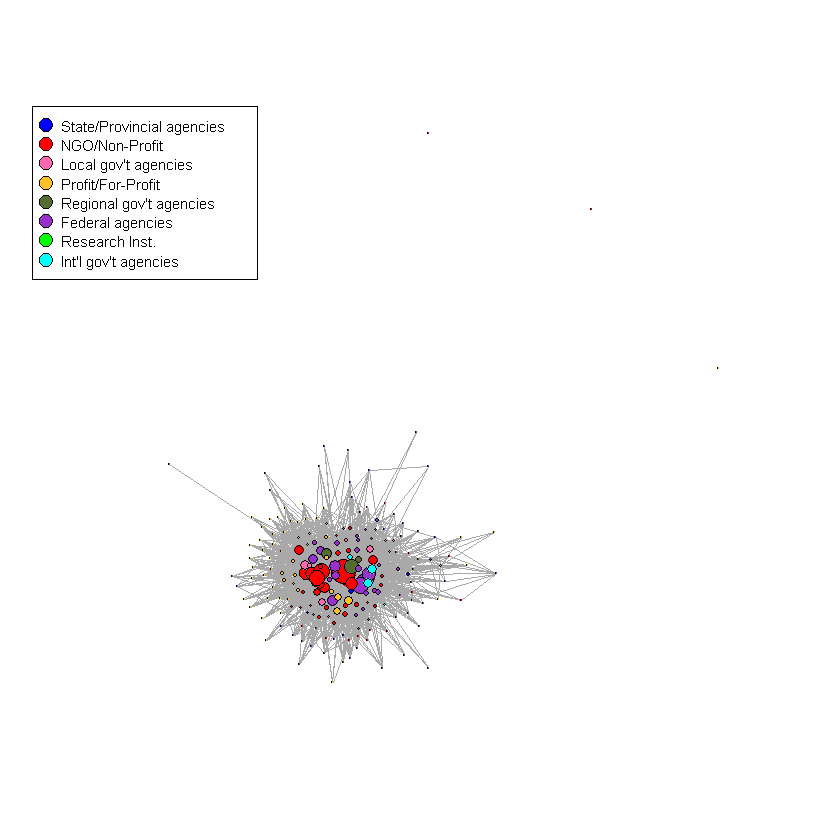

In [4]:
# setup the networks for mapping

# add degree value to use in sizing nodes in the network; degree is the number of links a node has
# measures normalized to be comparable
# normalization divides the observed degree by the total possible degree for the network
max.degree <- length(org.list$org.name) - 1
V(is.net)$size <- degree(is.net) / max.degree * 10
V(ta.net)$size <- degree(ta.net) / max.degree * 10
V(rt.net)$size <- degree(rt.net) / max.degree * 10
V(fs.net)$size <- degree(fs.net) / max.degree * 10
V(pc.net)$size <- degree(pc.net) / max.degree * 10

# Give the nodes color based on their sector
# colors were chosen the match previously-existing network maps
code.colors <- c("blue","red","hotpink","goldenrod1","darkolivegreen","darkorchid","green","cyan")
V(is.net)$color <- code.colors[V(is.net)$sector]
V(ta.net)$color <- code.colors[V(is.net)$sector]
V(rt.net)$color <- code.colors[V(is.net)$sector]
V(fs.net)$color <- code.colors[V(is.net)$sector]
V(pc.net)$color <- code.colors[V(is.net)$sector]

# load in Sector labels
sector.labels <- c("1" = "Federal agencies",
                   "2" = "State/Provincial agencies",
                   "3" = "Regional gov't agencies",
                   "4" = "Local gov't agencies",
                   "5" = "Profit/For-Profit",
                   "6" = "NGO/Non-Profit",
                   "7" = "Individuals",
                   "8" = "Research Inst.",
                   "9" = "Int'l gov't agencies")

# render the network map
plot(is.net,
     vertex.label = NA)
legend(x = -1.5,
       y = 1.1,
       legend = sector.labels[unique(V(is.net)$sector)],
       pt.bg = code.colors,
       pch = 21,
       pt.cex = 1.5,
       cex = 0.75,
       ncol = 1)

### Technical Assistance

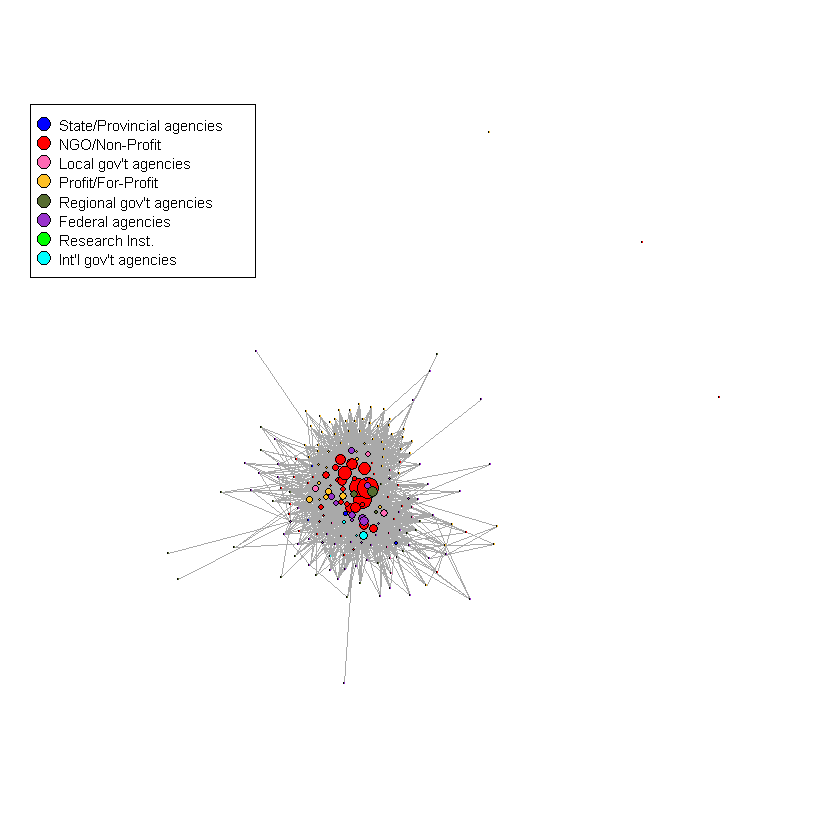

In [5]:
plot(ta.net,
     vertex.label = NA)
legend(x = -1.5,
       y = 1.1,
       legend = sector.labels[unique(V(is.net)$sector)],
       pt.bg = code.colors,
       pch = 21,
       pt.cex = 1.5,
       cex = 0.75,
       ncol = 1)

### Reporting

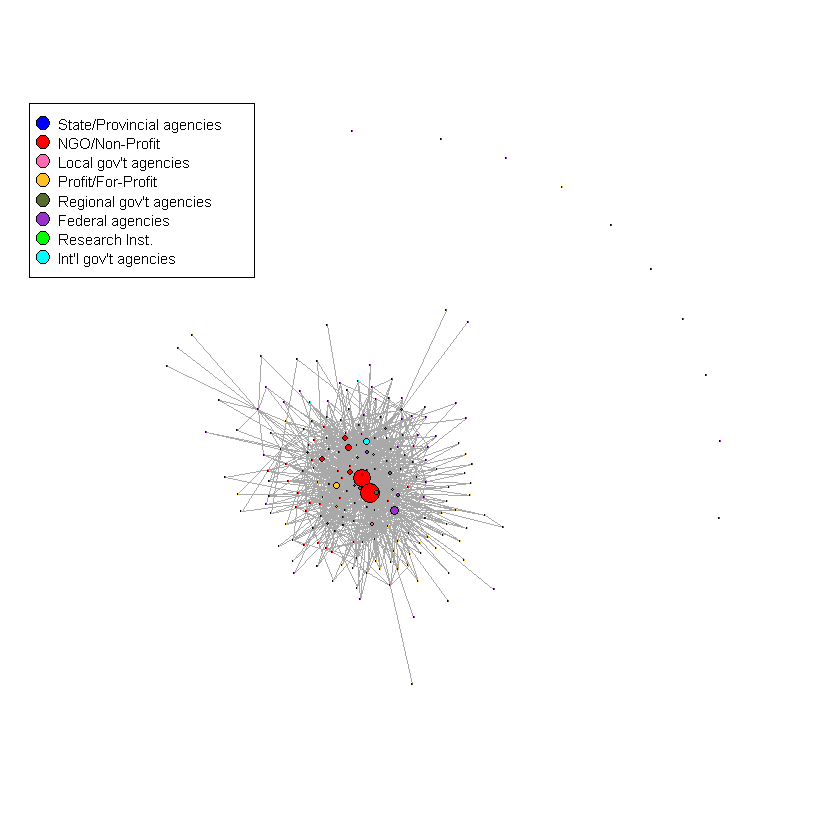

In [6]:
plot(rt.net,
     vertex.label = NA)
legend(x = -1.5,
       y = 1.1,
       legend = sector.labels[unique(V(is.net)$sector)],
       pt.bg = code.colors,
       pch = 21,
       pt.cex = 1.5,
       cex = 0.75,
       ncol = 1)

### Financial Resource Sharing

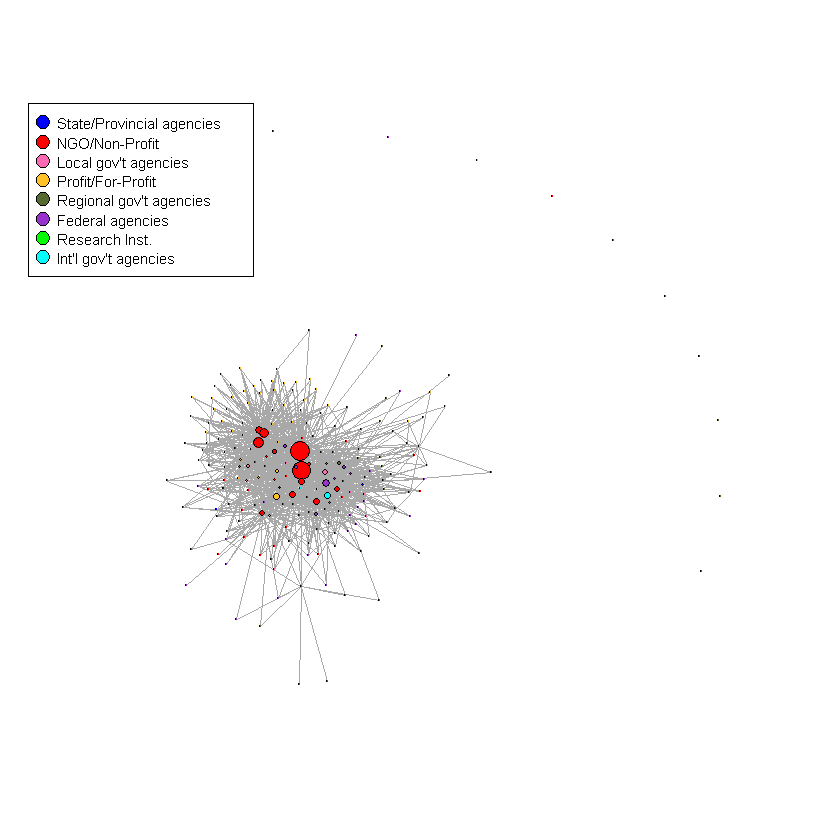

In [7]:
plot(fs.net,
     vertex.label = NA)
legend(x = -1.5,
       y = 1.1,
       legend = sector.labels[unique(V(is.net)$sector)],
       pt.bg = code.colors,
       pch = 21,
       pt.cex = 1.5,
       cex = 0.75,
       ncol = 1)

### Project Coordination & Collaboration

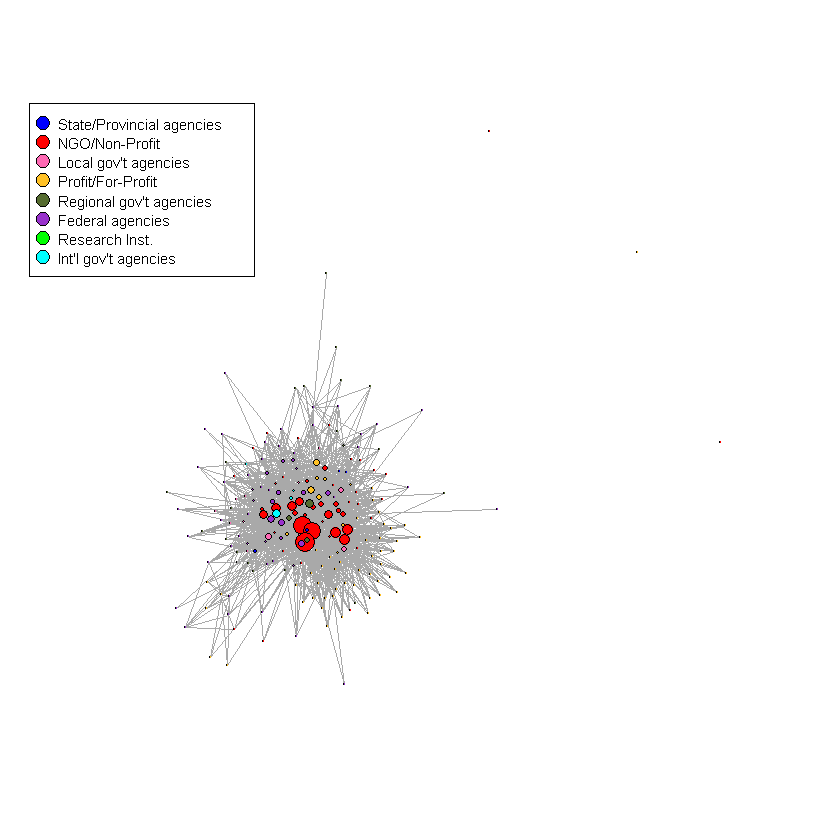

In [8]:
plot(pc.net,
     vertex.label = NA)
legend(x = -1.5,
       y = 1.1,
       legend = sector.labels[unique(V(is.net)$sector)],
       pt.bg = code.colors,
       pch = 21,
       pt.cex = 1.5,
       cex = 0.75,
       ncol = 1)

We can see quite clearly that these are large and complex networks and that finding out about any one node is difficult. In short, these networks are $not$ useful for communicating with non-specialists; they are what network analysts refer to as "Persian rugs" or "hairballs," meaning they are too large, matted, and dense to see anything meaningful. Well-connected nodes do stand out, but we can't idenify them and we can't see how they're connected; the cloud of nodes and links is just too dense, despite how low the density measurements our for all of these networks. To be able to see the network clearly, we need to exclude labels. The next map shows just how much more difficult it is to extract any information from this network when labels have been added.

### Information Sharing with Labels

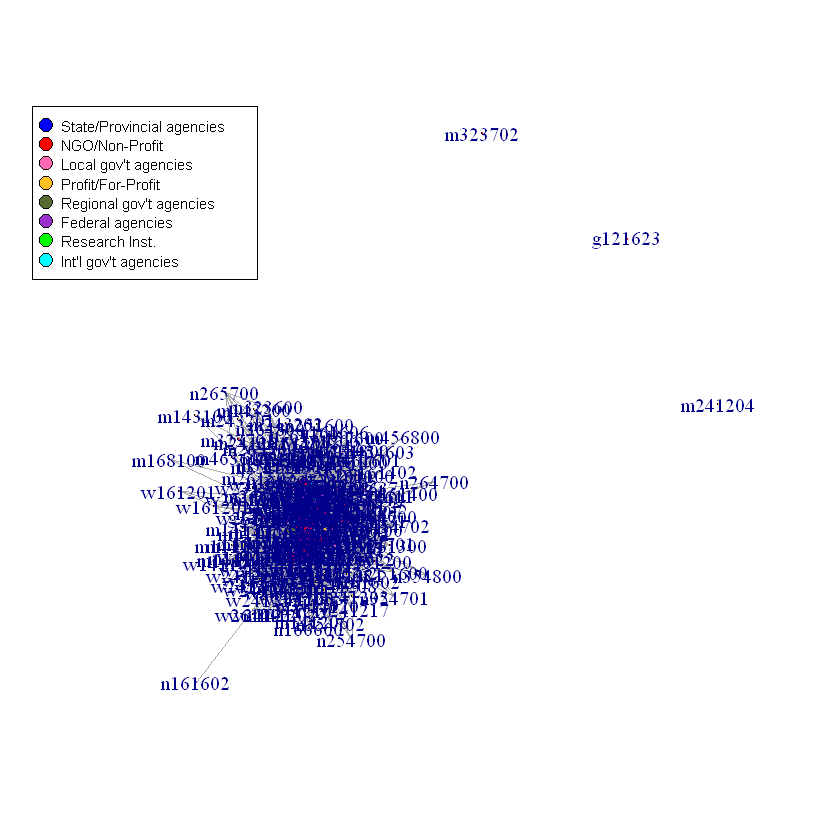

In [9]:
plot(is.net,
    # vertex.label = NA
    )
legend(x = -1.5,
       y = 1.1,
       legend = sector.labels[unique(V(is.net)$sector)],
       pt.bg = code.colors,
       pch = 21,
       pt.cex = 1.5,
       cex = 0.75,
       ncol = 1)

Without labels, we can't hope to find anyone organization, but with labels, the entire network is obscured. This map is even less useful than those above. And yet, when stakeholders first started to look at these maps, the positions and connections of individual organizations, often their own, was exactly what they asked about. Many wanted to know about their role and position, others wanted to proverbially "sniff test" the accuracy of the network. There are three alternate approaches:

1. Make bigger maps
2. Use interactive mapping
3. Make network slices

We could, of course, make physically larger maps. But there is a limit to how big these maps can be made, especially without printing them. And, indeed, they would have to be very large to be of use.

Interactive mapping can allow us to focus on parts of the whole by zooming in, providing only certain labels, and allowing for nodes to be manipulated. But it has limits, particularly that a network this big will be slow and cumbersome to manipulate. Also, it would fall on the analysts to be present for each stakeholder's individual exploration.

Network slices allow for a more focused look on specific pieces, whether their focused on a substantively-based piece of a network or the local neighborhood of a specific node. The former of these focuses, the substantively-based pieces, is something that can be anticipated, as there are only a limited selection of these pieces.

## Substantively-based network slices

The survey that collected these data, along with asking about interactions, asked about organizations' use of a range of policy tools and involvement in a range of policy domains, action arenas, and geographic areas. Policy tools are the different mechanisms that policy makers write into policy so that that policy will have an impact once implemented. Regulations are the best known, but they also include measures like cost sharing, grants, loans and guarantees, permitting, and public information. The survey collected data on 12 such tools, with the full list included in the data's codebook. Domains are policy issues that around which policy is made. In the survey, six domains, such as agricultural land management, river corridors, and development were included. Action arenas are the spaces in which organizations interact. Many are physical spaces, though this is not necessary. This data includes another 12 action arenas, including several different legislative committees, regional planning commissions, the US EPA-initiated Total Maximum Daily Load (TMDL) revision and implementation planning, Vermont's tactical basin planning, and the Lake Champlain Basin Program.

For demonstration purposes, we will look at a map of one of these: the EPA-initiated TMDL. The EPA was rewriting Vermont's Phosphorus TMDL while these data were gathered, and it remains an important issue in Vermont. Many stakeholders are particularly interested in the networks surrounding this effort, both to see how the plans are being written and how the plans will be implementing. So, let's look at the map for the organizations involved in the TMDL and how they are sharing information.

In [10]:
# mapping will be done by limiting the available organizations. Organizations identified involvement
#   and those organizations that identified involvement will be included. Those that do not will be
#   excluded.
# Data for action arena involvement are stored as part of a bi-modal data set, which named for
#   bi-modal network data.

# load in bi-modal data and join with the existing org list
bi.data <- read.csv("data/bimodal data sets 2015.csv")

# for simplicity, cut down to just ids and the TMDL data
tmdl.data <- bi.data[,c(1,41)]
colnames(tmdl.data) <- c("anon.id","TMDL")

# merge this data into the main org list
org.list.tmdl <- left_join(org.list,
                           tmdl.data,
                           by = c("org.name" = "anon.id"))

# because not all organizations are in the TMDL network, some entries in the org list are assigned NA
#  but NA is equivalent to 0, meaning not involved.
# therefore, replacing NA's with 0's, but only for the TMDL column
org.list.tmdl$TMDL[is.na(org.list.tmdl$TMDL)] <- 0

# filter out zeros, to obtain a TMDL-specific org list
# clean by removing the TMDL column and any duplicate rows derived from orgs having had multiple
#   respondents who gave different answers to the TMDL involvement question
org.list.tmdl <- org.list.tmdl[org.list.tmdl$TMDL == 1,]
org.list.tmdl <- unique(org.list.tmdl[,-10])

head(org.list.tmdl)

,org.name,group,completed.2014,capacity,sector,jurisdiction,juris.level,winooski,missisquoi
1,g321601,Government,N/A,3,2,1,6,Yes,Yes
3,g321603,Government,Y,3,2,1,6,Yes,Yes
12,n454701,NGO,Y,4,5,4,7,Yes,Yes
16,n261501,NGO,Y,2,6,1,5,Yes,No
17,w231401,Winooski,Y,2,3,1,4,Yes,No
21,w241216,Winooski,Y,2,4,1,2,Yes,No


In [11]:
# filter the IS edgelist so that in contains only those organizations that are involved in the TMDL (see function above)
is.el.tmdl <- filter.el( is.el, org.list.tmdl$org.name)

# make a TMDL network
is.net.tmdl <- graph.data.frame(is.el.tmdl,
                                directed = F,
                                vertices = org.list.tmdl)
is.net.tmdl <- simplify(is.net.tmdl)

# gather degree values and assign node colors for mapping
max.degree <- length(org.list.tmdl$org.name) - 1
V(is.net.tmdl)$size <- degree(is.net.tmdl) / max.degree * 10
V(is.net.tmdl)$color <- code.colors[V(is.net.tmdl)$sector]

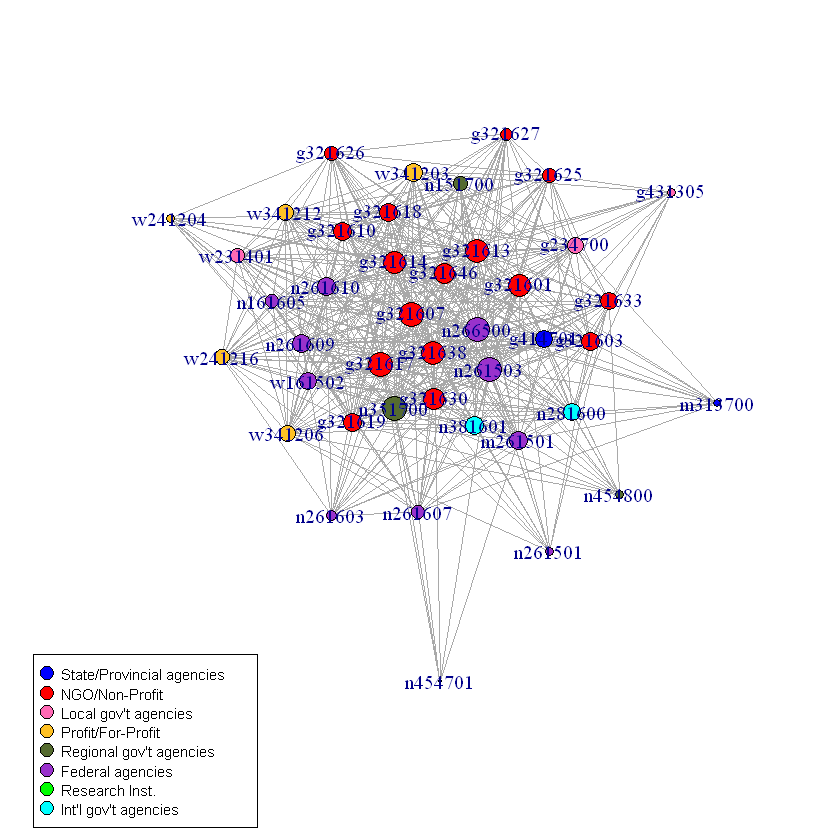

In [22]:
# generate network map
plot(is.net.tmdl
     #vertex.label = NA
     )
legend(x = -1.5,
       y = -0.9,
       legend = sector.labels[unique(V(is.net)$sector)],
       pt.bg = code.colors,
       pch = 21,
       pt.cex = 1.5,
       cex = 0.75,
       ncol = 1)

This is a much more readable map. It is still dense and still has problems with node label overlaps, but it is far better.

Many organizations also want to look at their proverbial neighborhood, the organizations that they connect to. For example, organization $g321646$ is a well connected organization in this network. Let's look at that organization's local neighborhood.

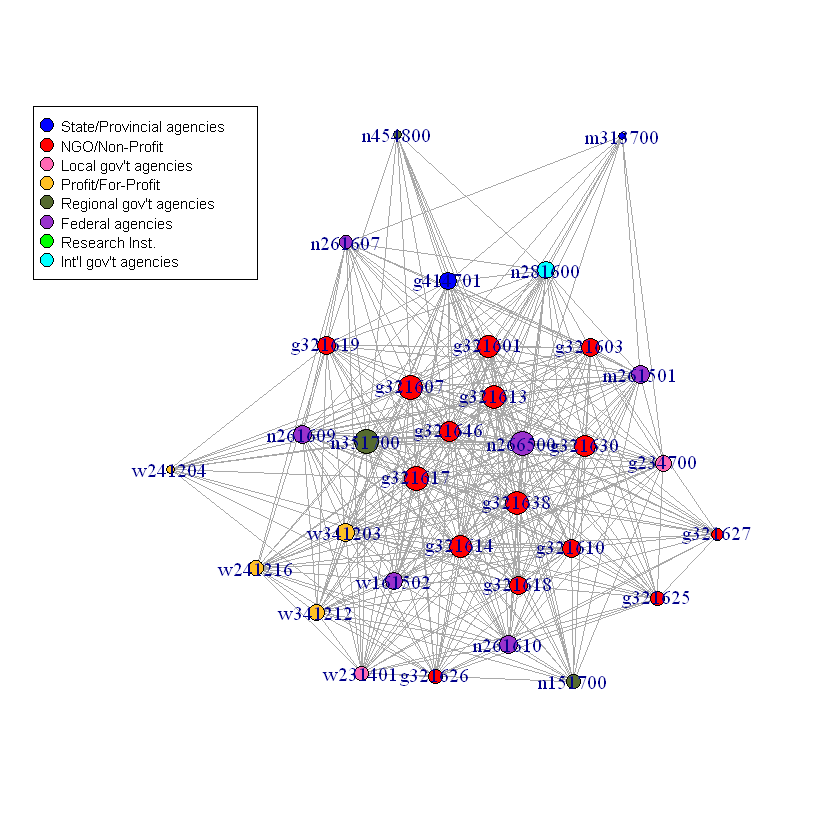

In [13]:
# make the ego net graph objects
ego.net <- make_ego_graph(is.net.tmdl,
                          nodes = "g321646")

# render the ego net map for g321646
plot(ego.net[[1]])
legend(x = -1.5,
       y = 1.1,
       legend = sector.labels[unique(V(is.net)$sector)],
       pt.bg = code.colors,
       pch = 21,
       pt.cex = 1.5,
       cex = 0.75,
       ncol = 1)

As expected, organization $g321646$ has a large and involved neighborhood, but it is an even more easily read map, and one that a number of stakeholders are likely to be interested in.

## Interactive Mapping

Static maps, like those we have been looking at so far, are still limited, especially if you want to look at a larger network and its greater context. Interactive maps allow us to look deeper. Though, even they have limits, as large networks will be slow and cumbersome. Still, interactive maps, with some patience and a good execution can open up the larger maps for exploration. Let's look at that TMDL map again, using an interactive display.

In [14]:
# restructure node list for use in interactive map
# first get sector labels into the org list as an attribute
org.list.tmdl$sector.group <- sector.labels[org.list.tmdl$sector]
# second, merge degree data as attribute
degrees <- data.frame(degree(is.net.tmdl))
degrees <- cbind(data.frame(rownames(degrees)),
                       degrees[,1])
colnames(degrees) <- c("org.name", "degree")
nodes <- left_join(org.list.tmdl,
                         degrees,
                         by = "org.name")
degrees$degree <- ( degrees$degree / ( nrow(nodes) - 1 ) ) * 10
      
# make node labels
nodes$tool.tip <- paste(nodes$org.name,
                        " - ",
                        round(nodes$degree, digits = 2),
                        "%",
                        sep = "")

nodes.d3 <- cbind(org.name.f = factor(nodes$org.name, levels = nodes$org.name), nodes)
nodes.d3 <- nodes.d3[order(nodes.d3$org.name),]

In [15]:
# restructure links for use in interactive map
links <- data.frame(get.edgelist(is.net.tmdl))
colnames(links) <- c("from", "to")        # reassign column names

links.d3 <- links
links.d3 <- links.d3[order(links.d3$from),]
links.d3$from.index <- match(links.d3$from, nodes.d3$org.name) - 1
links.d3$to.index <- match(links.d3$to, nodes.d3$org.name) - 1

In [16]:
# render the interactive map
forceNetwork(Links = links.d3,
             Nodes = nodes.d3,
             Source = "from.index",
             Target = "to.index",
             NodeID = "tool.tip", 
             Group = "sector.group",
             Nodesize = "degree",
             #colourScale = Dark2,
             height = 400,
             width = 950,
             legend = T,
             zoom = T,
             fontSize = 12
             ) # end of forceNetwork

HTML widgets cannot be represented in plain text (need html)

Finally, we have a map that non-specialist stakeholders can engage with and explore. By making the map interactive, anyone exploring the map can dig deeper into the parts that interest them the most.

## Shiny App

The final challenge is that it took this long to arrive at such a map, meaning, that, any non-specialist who wants to explore must contact an analyst and ask for a specific map. With over 200 hundred organizations, the vast majority of which have multiple staff members who will all have different interests, different curiosities, and make different observations. Meeting this demand would swamp any analyst. This work was done using R as R has the $Shiny$ package, which supports the construction of web-based applications. Completing and posting this application to a hosting site, such as www.ShinyApps.io, will make the maps shown here available to anyone with internet access, while not requiring an specialized knowledge in networks and network analysis. On this site, stakeholders can explore on their own, only asking questions that require deeper analysis.

Construction of this app has begun, and currently offers interactive maps using full subnetworks. It does not yet offer any of the network slices depicted here. Upcoming versions will offer those slices.

The current version of the app also has yet to be posted to a hosting site. This will be done when the app is completed. The current version is available for download from Github: https://github.com/wmirecon/Visualizing_Gov_Nets/tree/master/shiny.